## --- Generate text with a recurrent neural network (Pytorch) ---
### (Mostly Read & Run)

The goal is to replicate the (famous) experiment from [Karpathy's blog](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

To learn to generate text, we train a recurrent neural network to do the following task:

Given a "chunk" of text: `this is random text`

the goal of the network is to predict each character in **`his is random text` ** sequentially given the following sequential input **`this is random tex`**:




## Load text (dataset/input.txt)

Before building training batch, we load the full text in RAM

In [10]:
import wget
url='https://thome.isir.upmc.fr/classes/RITAL/input.txt'
output_file='input.txt'

wget.download(url, out=output_file)

'input.txt'

In [11]:
! pip install unidecode

You should consider upgrading via the 'C:\Users\hatem\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [18]:
import unidecode
import string
import random
import re
import torch
import torch.nn as nn

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('input.txt').read()) #clean text => only ascii
file_len = len(file)
print('file_len =', file_len)


100
file_len = 1115394


## 2: Helper functions:

We have a text and we want to feed batch of chunks to a neural network:

one chunk  A,B,C,D,E
[input] A,B,C,D -> B,C,D,E [output]

Note: we will use an embedding layer instead of a one-hot encoding scheme.

for this, we have 3 functions:

- One to get a random str chunk of size `chunk_len` : `random_chunk`
- One to turn a chunk into a tensor of size `(1,chunk_len)` coding for each characters : `char_tensor`
- One to return random input and output chunks of size `(batch_size,chunk_len)` : `random_training_set`




In [15]:
import time, math


#Get a piece of text
def random_chunk(chunk_len):
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]


# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(1,len(string)).long()
    for c in range(len(string)):
        tensor[0,c] = all_characters.index(string[c])
    return tensor


#Turn a piece of text in train/test
def random_training_set(chunk_len=200, batch_size=8):
    chunks = [random_chunk(chunk_len) for _ in range(batch_size)]
    inp = torch.cat([char_tensor(chunk[:-1]) for chunk in chunks],dim=0)
    target = torch.cat([char_tensor(chunk[1:]) for chunk in chunks],dim=0)

    return inp, target

print(random_training_set(10,4))  ## should return 8 chunks of 10 letters.

(tensor([[27, 96, 54, 30, 11, 29, 21, 34, 94, 17],
        [14, 73, 94, 28, 17, 14, 68, 21, 21, 94],
        [94, 15, 24, 33, 14, 28, 73, 94, 16, 14],
        [17, 18, 28, 75, 94, 43, 24, 32, 94, 32]]), tensor([[96, 54, 30, 11, 29, 21, 34, 94, 17, 10],
        [73, 94, 28, 17, 14, 68, 21, 21, 94, 23],
        [15, 24, 33, 14, 28, 73, 94, 16, 14, 14],
        [18, 28, 75, 94, 43, 24, 32, 94, 32, 18]]))


## The actual RNN model (only thing to complete):

It should be composed of three distinct modules:

- an [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) (n_characters, hidden_size)

```
nn.Embedding(len_dic,size_vec)
```
- a [recurrent](https://pytorch.org/docs/stable/nn.html#recurrent-layers) layer (hidden_size, hidden_size)
```
nn.RNN(in_size,out_size) or nn.GRU() or nn.LSTM() => rnn_cell parameter
```
- a [prediction](https://pytorch.org/docs/stable/nn.html#linear) layer (hidden_size, output_size)

```
nn.Linear(in_size,out_size)
```
=> Complete the `init` function code

In [19]:
import torch.nn.functional as f

class RNN(nn.Module):

    def __init__(self, n_char, hidden_size, output_size,rnn_cell=nn.RNN):
        """
        Create the network
        """
        super(RNN, self).__init__()

        self.n_char = n_char
        self.hidden_size = hidden_size
        self.output_size = output_size

        #  (batch,chunk_len) -> (batch, chunk_len, hidden_size)
        self.embed = nn.Embedding(n_char,hidden_size)

        # (batch, chunk_len, hidden_size)  -> (batch, chunk_len, hidden_size)
        self.rnn = nn.RNN(hidden_size,hidden_size)

        #(batch, chunk_len, hidden_size) -> (batch, chunk_len, output_size)
        self.predict = nn.Linear(hidden_size,output_size)

    def forward(self, input):
        """
        batched forward: input is (batch > 1,chunk_len)
        """
        input=self.embed(input)
        output,_  = self.rnn(input)
        output = self.predict(f.tanh(output))
        return output

    def forward_seq(self, input,hidden=None):
        """
        not batched forward: input is  (1,chunk_len)
        """
        input = self.embed(input)
        output,hidden  = self.rnn(input.unsqueeze(0),hidden)
        output = self.predict(f.tanh(output))
        return output,hidden


## Text generation function

Sample text from the model

In [20]:
def generate(model,prime_str='A', predict_len=100, temperature=0.8):
    prime_input = char_tensor(prime_str).squeeze(0)
    hidden = None
    predicted = prime_str+""
    # Use priming string to "build up" hidden state

    for p in range(len(prime_str)-1):
        _,hidden = model.forward_seq(prime_input[p].unsqueeze(0),hidden)

    #print(hidden.size())
    for p in range(predict_len):
        output, hidden = model.forward_seq(prime_input[-1].unsqueeze(0), hidden)
                # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        #print(output_dist)
        top_i = torch.multinomial(output_dist, 1)[0]
        #print(top_i)
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        prime_input = torch.cat([prime_input,char_tensor(predicted_char).squeeze(0)])

    return predicted



## Training loop for net

In [24]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

###Parameters
n_epochs = 20000
print_every = 100
plot_every = 10
hidden_size = 100
lr = 0.005
batch_size = 16
chunk_len = 80

####

model = RNN(n_characters, hidden_size, n_characters) #create model
model_optimizer = torch.optim.Adam(model.parameters(), lr=lr) #create Adam optimizer
criterion = nn.CrossEntropyLoss() #chose criterion

start = time.time()
all_losses = []
loss_avg = 0


def train(inp, target):
    """
    Train sequence for one chunk:
    """
    #reset gradients
    model_optimizer.zero_grad()

    # predict output
    output = model(inp)

    #compute loss
    loss =  criterion(output.view(batch_size*chunk_len,-1), target.view(-1))

    #compute gradients and backpropagate
    loss.backward()
    model_optimizer.step()

    return loss.data.item()



for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set(chunk_len,batch_size))  #train on one chunk
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(generate(model,'Wh', 100), '\n')



    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0


 5s (100 0%) 2.5292]
Wh he chy e m byof itesore antopouro,
Wethe wip onoreanomy touringrend thilinou ty are ar my t hocais  

 9s (200 1%) 2.4569]
Whe my.
Thay, mbce an chin s win aroures heng fenontou mer tran d lin ofor ng
Band penond qumeyourir i 

 12s (300 1%) 2.4903]
Whe d
ADERDUMorkisod bengist ther INAn y haveveden ce tharer brestor k the tin:
Whal mente hend d hito 

 16s (400 2%) 2.4997]
Whind fine, thand wasthyosawhothe d mes har;
Andof end t bengrous frores se't G
ONA:
Coshand he o bano 

 19s (500 2%) 2.4661]
Whenostheifous nde iteatierofre nthaped in d ps?
Whe pess t helo s prd,
A:

pore t andothatulll f er t 

 23s (600 3%) 2.5384]
Whtas t may t

Weren arserpa d t
Wh at ft pr ke l t t it theanw alill bield he he andive m de hane t t 

 28s (700 3%) 2.4673]
Whe huraron:

ANot.
Myounge anowe, I ty char l ws ard sineemavord fundimesthis poooul ber whiseve d mb 

 31s (800 4%) 2.4910]
When l ougere br!
Wit ived d I e fullds s me whaionthell mesith fart thirerdstaritheecoulis

## Visualize loss

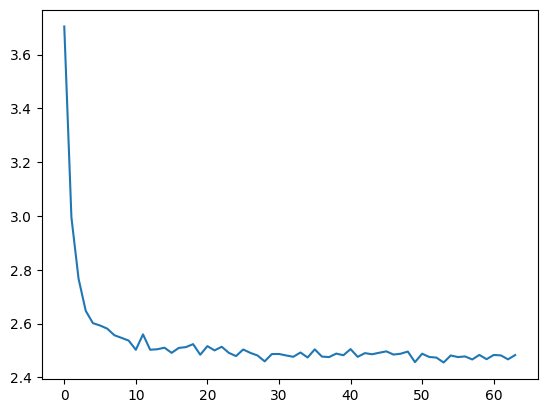

In [22]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

## Try different temperatures

Changing the distribution sharpness has an impact on character sampling:

more or less probable things are sampled

In [23]:
print(generate(model,'T', 200, temperature=1))
print("----")
print(generate(model,'Th', 200, temperature=0.8))
print("----")

print(generate(model,'Th', 200, temperature=0.5))
print("----")

print(generate(model,'Th', 200, temperature=0.3))
print("----")

print(generate(model,'Th', 200, temperature=0.1))

TRHealol wim?
Yont is ayo t; as.
G thenome t ary bue: theelisthe hes GSBETharnd atr imat gcar taginouinthalllofotofo hor fe hisisirs fon GRORCAn t celo l ghend ane onfill samaller, hy.
Prnimy fiven pia
----
The n RLAnorere s, t g t memy athor s lious f o, sotowinonean on?
O:


ARRS:
Ther:
Thithor wathitr?

MPeru, houth s herenomis pit te ry n fofar nde t be

A:
Whelud tat t st tht ther, thoncrer hert p, pi
----
Then her he s winor me ancominor t the t ing t ou be at t athine ant y be st tho merathand the bller the t t the me thind sthe at ar thin t t thyomathethare n s ous hatheatharof the f ousthe me at agh i
----
The the thand t t he the t the the the t t t the t t t thanon t the t t t thor t than theneror t t t t wis thare thathe wer t thend wererer t t the athather and t t and t t t t the ber t then t athe t t
----
The the the the the the the the t t the t the the the the the the t the the the t the the t the t the the the the the the the t t the the the the t the the t the t the t

### Improving this code:

(a) Tinker with parameters:

- Is it really necessary to have 100 dims character embeddings
- Chunk length can be gradually increased
- Try changing RNN cell type (GRUs - LSTMs)

(b) Add GPU support to go faster
